In [1]:
!pip install deeptrack

     |████████████████████████████████| 80 kB 3.2 MB/s 
     |████████████████████████████████| 679 kB 6.8 MB/s 


In [2]:
import matplotlib.pyplot as plt
import deeptrack as dt
import numpy as np
import cv2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Simulating(2-D representation) Janus Particle 3d orientation with azimuthal and polar angle 

In [13]:
IMAGE_SIZE = 128


class DarkBrightParticle(dt.Feature):

    def get(self, image, position, radius, intensityOfBright, rotation, **kwargs):
        X, Y = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))
        mask = ((X - position[0]) ** 2 + (Y - (position[1])) ** 2 <= radius ** 2)*1.0
        # rotation[1] 0 to 90
        if rotation[1] >= 0 and rotation[1] <= np.pi / 2:
            
            line_center = [position[0] + int(radius * rotation[1] / (np.pi / 2) * np.cos(rotation[0] - np.pi / 2)),
                           position[1] - int(radius * rotation[1] / (np.pi / 2) * np.sin(rotation[0] - np.pi / 2))]

            if np.sin(rotation[0]) == 1:
                for y in range(image.shape[1]):
                    for x in range(image.shape[0]):
                        if mask[y, x]:
                            if x >= int(line_center[0]):
                                mask[y, x] = intensityOfBright
            elif np.sin(rotation[0]) == -1:
                for y in range(image.shape[1]):
                    for x in range(image.shape[0]):
                        if mask[y, x]:
                            if x <= int(line_center[0]):
                                mask[y, x] = intensityOfBright
            else:
                for y in range(image.shape[0]):
                    for x in range(image.shape[1]):
                        if mask[y, x]:
                            if (np.sin(rotation[0]) >= 0 and np.cos(rotation[0]) > 0) or (
                                    np.sin(rotation[0]) < 0 and np.cos(rotation[0]) > 0):
                                if (y - (line_center[1])) > np.tan(np.pi - rotation[0]) * (x - (line_center[0])):
                                    mask[y, x] = intensityOfBright
                            elif (np.sin(rotation[0]) >= 0 and np.cos(rotation[0]) < 0) or (
                                    np.sin(rotation[0]) < 0 and np.cos(rotation[0]) < 0):
                                if (y - (line_center[1])) < np.tan(np.pi - rotation[0]) * (x - (line_center[0])):
                                    mask[y, x] = intensityOfBright

        
        # rotation[1] -90 to 0
        if rotation[1] < 0  and rotation[1] >= -1* np.pi/2:
            
            line_center = [position[0] - int(radius * (-1*rotation[1]) / (np.pi / 2) * np.cos(
                rotation[0] - np.pi / 2)) , position[1] + int(
                radius * (-1*rotation[1]) / (np.pi / 2) * np.sin(
                    rotation[0] - np.pi / 2)) ]


            if np.sin(rotation[0]) == 1:
                for y in range(image.shape[1]):
                    for x in range(image.shape[0]):
                        if mask[y, x]:
                            if x >= int(line_center[0]):
                                mask[y, x] = intensityOfBright
            elif np.sin(rotation[0]) == -1:
                for y in range(image.shape[1]):
                    for x in range(image.shape[0]):
                        if mask[y, x]:
                            if x <= int(line_center[0]):
                                mask[y, x] = intensityOfBright
            else:
                for y in range(image.shape[0]):
                    for x in range(image.shape[1]):
                        if mask[y, x]:
                            if (np.sin(rotation[0]) > 0 and np.cos(rotation[0]) > 0) or (
                                    np.sin(rotation[0]) < 0 and np.cos(rotation[0]) > 0):
                                if (y - (line_center[1])) > -1*np.tan(rotation[0]) * (x - (line_center[0])):
                                    mask[y, x] = intensityOfBright
                            elif (np.sin(rotation[0]) > 0 and np.cos(rotation[0]) < 0) or (np.sin(rotation[0]) < 0 and np.cos(rotation[0]) < 0):
                                if (y - (line_center[1])) < -1*np.tan(rotation[0] ) * (x - (line_center[0])):
                                    mask[y, x] = intensityOfBright

        mask  = -1*(mask - 1)
        
        return mask
    

class Updater(dt.Feature):
    
    __distributed__ = False
    
    def __init__(self, feature=None, **kwargs):
        super().__init__(features=feature, **kwargs)
        
    def get(self, image, features, **kwargs):
        return features.resolve(
            np.ones(
                (IMAGE_SIZE,IMAGE_SIZE)
                )
            )


particle = DarkBrightParticle(
    position=lambda: (np.random.rand(2) * (40)).astype(int) + 40,
    radius=lambda: 7 + np.random.rand()*1.5,
    rotation = lambda: np.array([np.random.rand()*2*np.pi, np.random.rand()*np.pi/2 if np.random.randint(2) == 0 else np.random.rand()*-1*np.pi/2 ]),
    intensityOfBright=0.3
)


gradient = dt.IlluminationGradient(
    gradient=[2e-3, 2e-3],
)

normalization = dt.NormalizeMinMax(0, 1)

noise = dt.Poisson(
    snr=lambda: np.random.rand()*10 + 20,
    background=lambda: normalization.min
)

circles = particle 
circles = Updater(circles)
import scipy

#Smoothing
kernel = np.ones((4, 4)) / 15
smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel)) 

circles += smoothing + gradient + noise + normalization

In [14]:
def get_label(image):
    position = np.array(image.get_property("position")) / IMAGE_SIZE   
    return (position[0], position[1])


/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


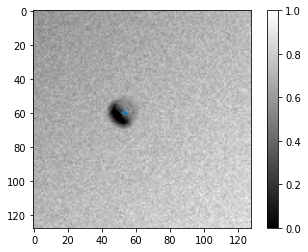

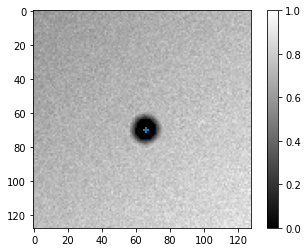

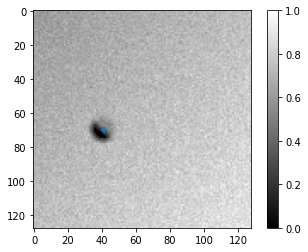

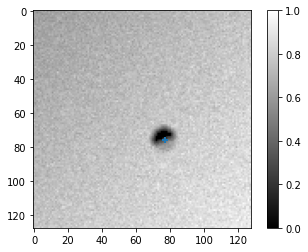

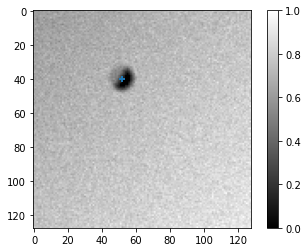

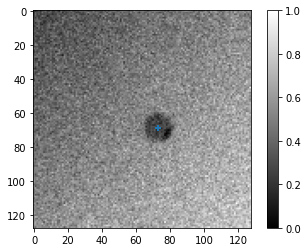

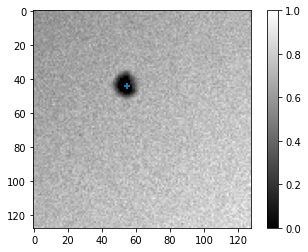

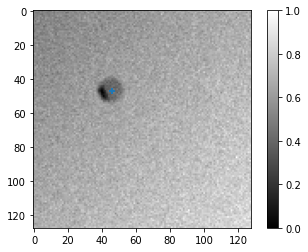

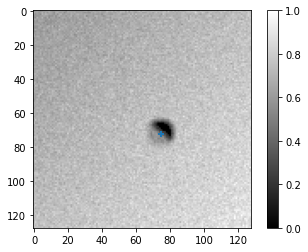

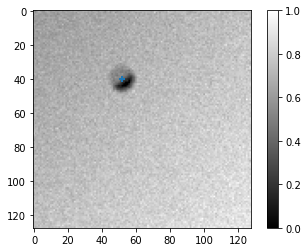

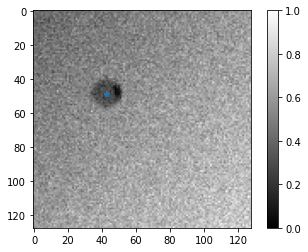

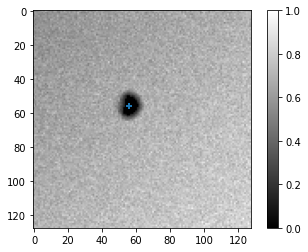

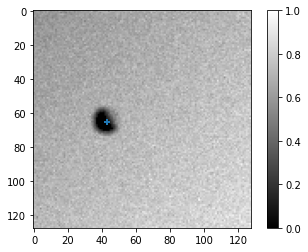

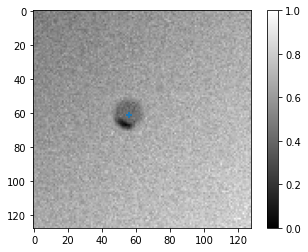

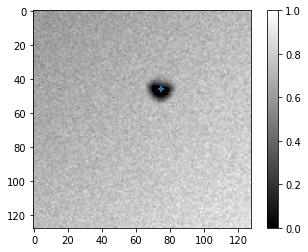

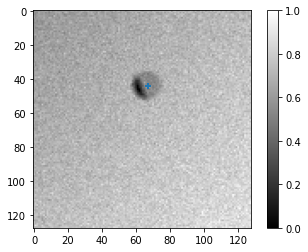

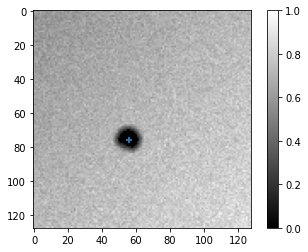

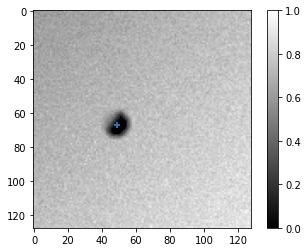

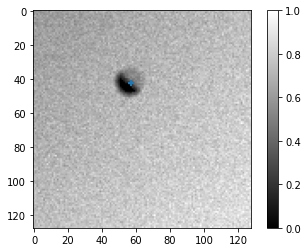

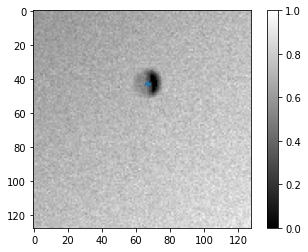

In [16]:
#Example Simulation Images
NUMBER_OF_IMAGES = 20

for _ in range(NUMBER_OF_IMAGES):
    circles.update()
    image_of_particle = circles.resolve()
    label = get_label(image_of_particle)
    position_of_particle = np.array([label[0], label[1]])
    position_of_particle = position_of_particle * IMAGE_SIZE 
    
    plt.imshow(image_of_particle, cmap="gray")
    plt.colorbar()
    plt.scatter(position_of_particle[0], position_of_particle[1], marker='+', edgecolors="r", linewidth=2)
    plt.show()

# Defining the Network

In [ ]:
# Defining the NEtwork
import keras.backend as K
import keras.optimizers as optimizers
import tensorflow as tf
def pixel_error(T, P):
    return K.mean(K.sqrt(K.sum(K.square(T - P), axis=-1))) * IMAGE_SIZE

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16, 32, 64, 64),
    dense_layers_dimensions=(32, 32),
    steps_per_pooling=1,
    number_of_outputs=2,
    loss="mse",
    metrics=[pixel_error],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    convolution_block=dt.layers.ConvolutionalBlock(kernel_size=5),
    dense_block=dt.layers.DenseBlock(activation="relu"),
    pooling_block=dt.layers.PoolingBlock(padding="valid")
)


model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      416       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0     

# Training the network

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


Generating 10047 / 10000 samples before starting training
Epoch 1/150
156/156 [==============================] - 38s 34ms/step - loss: 0.0137 - pixel_error: 16.5838 - val_loss: 0.0014 - val_pixel_error: 5.7497
Epoch 2/150
156/156 [==============================] - 5s 31ms/step - loss: 0.0010 - pixel_error: 4.8661 - val_loss: 5.5576e-04 - val_pixel_error: 3.6188
Epoch 3/150
156/156 [==============================] - 5s 31ms/step - loss: 4.7347e-04 - pixel_error: 3.3651 - val_loss: 3.5404e-04 - val_pixel_error: 2.9577
Epoch 4/150
156/156 [==============================] - 5s 30ms/step - loss: 3.3683e-04 - pixel_error: 2.8919 - val_loss: 2.9671e-04 - val_pixel_error: 2.7327
Epoch 5/150
156/156 [==============================] - 5s 31ms/step - loss: 3.0370e-04 - pixel_error: 2.7473 - val_loss: 2.6885e-04 - val_pixel_error: 2.6082
Epoch 6/150
156/156 [==============================] - 5s 31ms/step - loss: 2.5527e-04 - pixel_error: 2.5150 - val_loss: 2.2212e-04 - val_pixel_error: 2.3869
Epoc

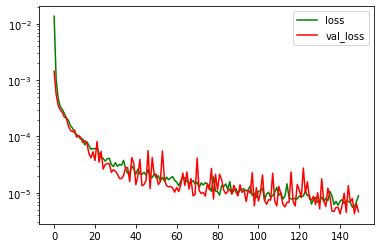

In [ ]:
# Training the model

TRAIN_MODEL = True

from tensorflow.keras.callbacks import EarlyStopping

validation_set_size = 200

validation_set = [circles.update().resolve()  for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        circles,
        get_label,
        min_data_size=int(1e+4),
        max_data_size=int(2e+4),
        batch_size=64
        
    )

    histories = []

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set),
                np.array(validation_labels)
            ),
            callbacks=[
                EarlyStopping(patience=20, restore_best_weights=True)
            ],
            epochs=150
        )

    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["loss", "val_loss"])
    plt.yscale('log')
    plt.show()

In [ ]:
model.save("/content/drive/MyDrive/3dOrientation_Network11")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/3dOrientation_Network11/assets


## Testing the network on simulated images

In [ ]:
model.load_weights("/content/drive/MyDrive/3dOrientation_Network11")

In [ ]:
n_images = 15

image_of_particle = []
for _ in range(n_images):
    circles.update()
    image_of_particle.append(circles.resolve())

img = np.array(image_of_particle)

/usr/local/lib/python3.7/dist-packages/deeptrack/optics.py:681: RuntimeWarning: invalid value encountered in true_divide
  image = amplitude * image / np.abs(image)


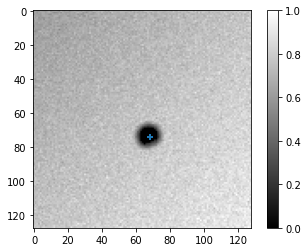

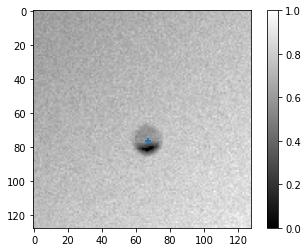

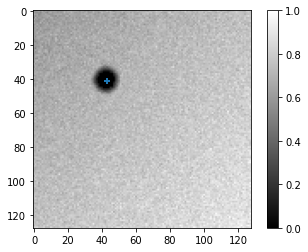

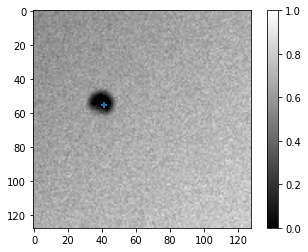

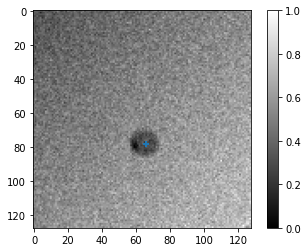

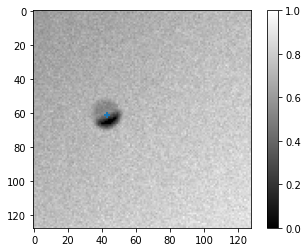

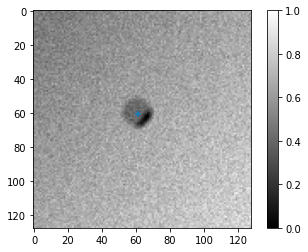

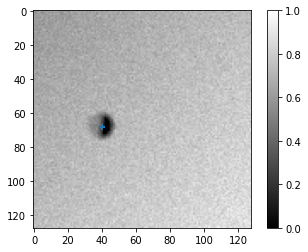

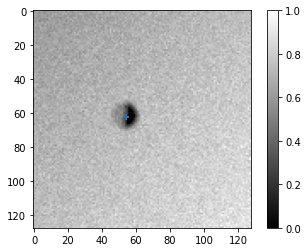

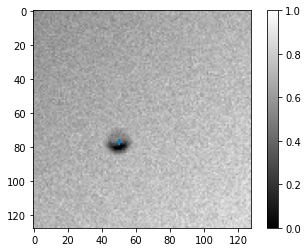

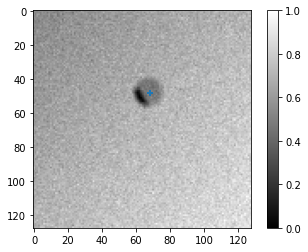

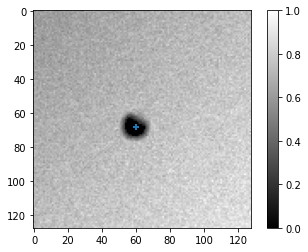

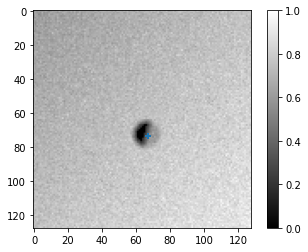

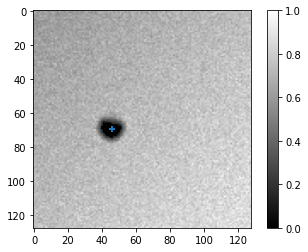

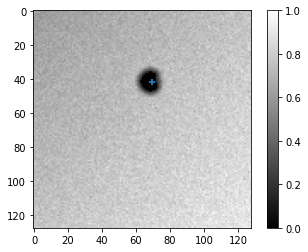

In [ ]:
prediction = model.predict(img)
for i in range(len(img)):
    position_of_particle = np.array([prediction[i,0], prediction[i,1]])
    position_of_particle = position_of_particle * IMAGE_SIZE 
    
    plt.imshow(img[i], cmap="gray")
    plt.colorbar()
    
    plt.scatter(position_of_particle[0], position_of_particle[1], marker='+', linewidth=2)
    plt.show()